In [1]:
#Notebooks for small tests
import os  
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
#imports and plotting function
import argparse
import mat73
import logging
import numpy as np
#import torchvision
from datetime import datetime
import os
import scipy.io
from torch.utils.data import DataLoader
import io
from PIL import Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import wandb
import math
import torch.nn.functional as F
import torchvision.transforms as T
import torch.nn as nn
import torch
import sys
import torch.optim.lr_scheduler as lr_scheduler
import wandb
import torch
from sklearn.preprocessing import StandardScaler
import Models as M
import Helpers as H
import time
from torch.func import vmap
from functorch.experimental import replace_all_batch_norm_modules_
%matplotlib inline

encoder_out='sigmoid'
cwd=os. getcwd()

data_path=os.path.join(cwd,'PNAS-regime_all_seeds/PNAS-regime_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))


(1450, 400)
(400, 400)
coherence of data:  0.7122178833397256


Medium: (1450, 400), Rho: (2000, 400), B: (2000, 1450)


Medium: (1450, 400), Rho: (3000, 400), B: (3000, 1450)
8281000
Data shapes: 1450.0 200.0


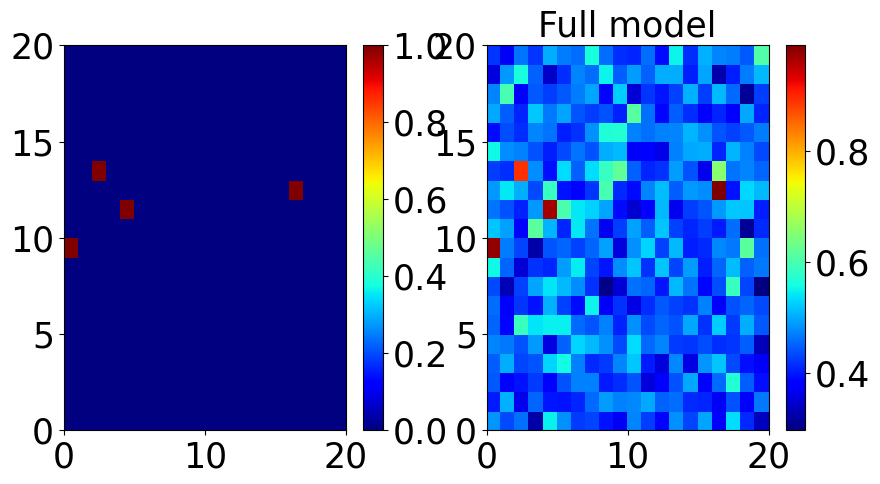

time for labeled: 13.193795680999756


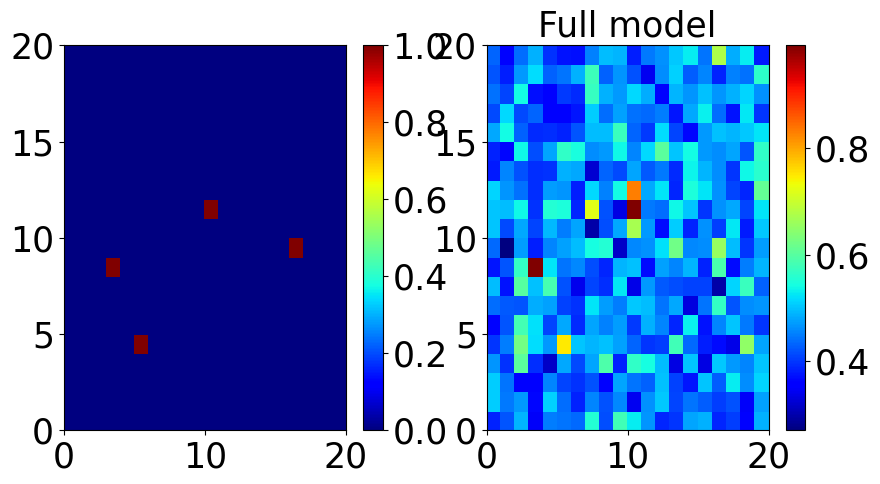

In [4]:
#Raw data training
starttime=time.time()
target='raw'
labeled_data=2000
layer_loss_list=[]
Epochs=10
Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=128
layers=[500,500, 500, 300, 300, 400,800]
training_data=H.data_rho_loaded(data_path+'/train',labeled_data/80000)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=4)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
valloader=DataLoader(val_data,batch_size=512,shuffle=True,num_workers=4)
encoder=M.fc_net_extra(training_data.b[0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)


relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss()   
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    for batch, (b,rho,num_targets) in enumerate(trainloader):
        optimizer.zero_grad()

        b=b.to(device)
        rho=rho.to(device)    
        if labeled_data==1:
            b=b.squeeze().unsqueeze(0).repeat(128,1).unsqueeze(1)  
            rho=rho.squeeze().unsqueeze(0).repeat(128,1).unsqueeze(1)
        font_size = 50
        rho_hat=encoder(b)
        rh, _=torch.split(rho, 400, dim=-1)
        if encoder_out=='sigmoid':
            #rho_hat=rho_hat-rho
            rho_hat=sigmoid(rho_hat)
        elif encoder_out=='softmax':
            rho_hat=5*softmax(rho_hat.squeeze())
        elif encoder_out=='relu':
            rho_hat=relu(rho_hat.squeeze())
        #rho_hat=relu(rho_hat.squeeze())
        #H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5)    
        if encoder_out=='sigmoid' or encoder_out=='softmax':
            #print(rho_hat.shape, rh.shape)
            bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
            bce_loss.backward() 
            train_lossavg+=bce_loss.item()/len(trainloader)

        else:
            L2_loss=L2_loss_fn(rho_hat.squeeze(), rh.squeeze())    
            L2_loss.backward()
            train_lossavg+=L2_loss.item()/len(trainloader)
        optimizer.step()
    if epoch==Epochs-1:
        H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
        finish=time.time()-starttime
        print(f"time for labeled: {finish}")
    wand_dict['train loss']=train_lossavg
    val_loss=0
    encoder.eval()
    for batch, (b,rho,num_targets) in enumerate(valloader):
        b=b.to(device)
        rho=rho.to(device)    
        font_size = 50
        rho_hat=encoder(b)
        if encoder_out=='sigmoid':
            rho_hat=sigmoid(rho_hat)
        elif encoder_out=='softmax':
            rho_hat=5*softmax(rho_hat.squeeze())
        elif encoder_out=='relu':
            rho_hat=relu(rho_hat.squeeze())
        #rho_hat=relu(rho_hat.squeeze())
        #H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5)    
        rh, _=torch.split(rho, 400, dim=-1)
        if encoder_out=='sigmoid' or encoder_out=='softmax':

            bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
            val_loss+=bce_loss.item()/len(valloader)
        else:
            L2_loss=L2_loss_fn(rho_hat.squeeze(), rh.squeeze())    
            val_loss+=L2_loss.item()/len(valloader)
    wand_dict['val loss']=val_loss
    if epoch==Epochs-1:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    if Track_run:
        wandb.log(wand_dict)

if Track_run:
    wandb.finish()


Medium: (1450, 400), Rho: (1600, 400), B: (1600, 1450)
Medium: (1450, 400), Rho: (3000, 400), B: (3000, 1450)
66061000
Data shapes: 725.0 200.0
epoch: 0, train loss: 0.7944405399836028
epoch: 1, train loss: 0.7421224942574135
epoch: 2, train loss: 0.6906708845725427
epoch: 3, train loss: 0.6760131120681763
epoch: 4, train loss: 0.6675966290327219
epoch: 5, train loss: 0.660386323928833
epoch: 6, train loss: 0.6539390499775226
epoch: 7, train loss: 0.6475371810106131
epoch: 8, train loss: 0.6410981554251451
epoch: 9, train loss: 0.6351914635071387
epoch: 10, train loss: 0.6293011216016916
epoch: 11, train loss: 0.6234329296992375
epoch: 12, train loss: 0.6176920166382422
epoch: 13, train loss: 0.6119608924939083
epoch: 14, train loss: 0.6062452472173251
epoch: 15, train loss: 0.6006056482975299
epoch: 16, train loss: 0.5951395355738126
epoch: 17, train loss: 0.5896123464290912
epoch: 18, train loss: 0.5841184625258813
epoch: 19, train loss: 0.5786985250619742
epoch: 20, train loss: 0.57

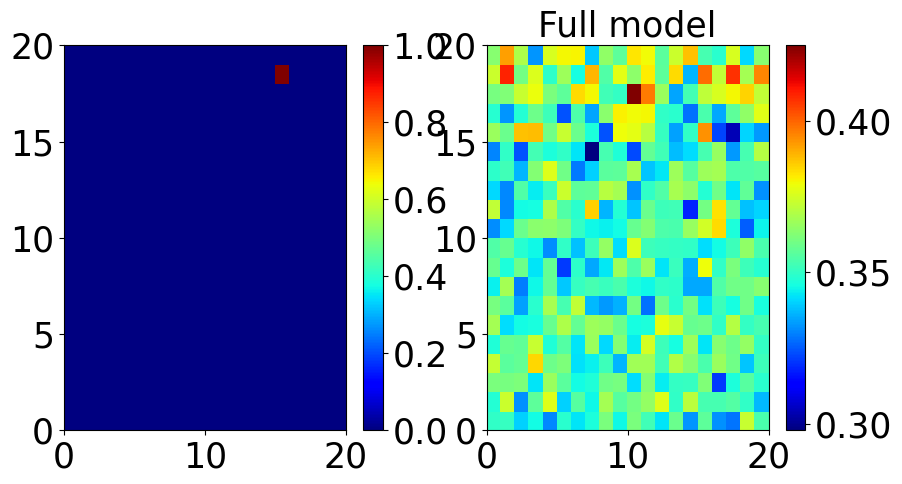

time for labeled: 1846.3922185897827
epoch: 49, train loss: 0.4407352484189547


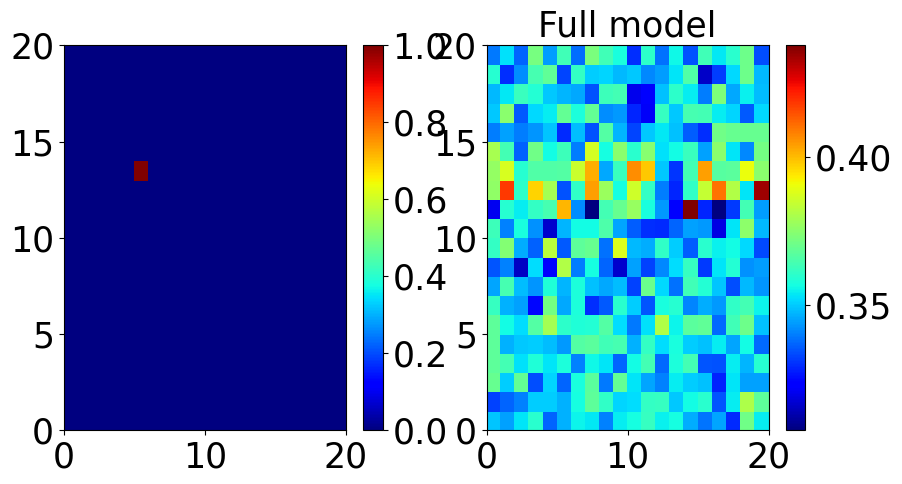

In [2]:
#cc data training
starttime=time.time()
target='raw'
labeled_data=1600
layer_loss_list=[]
OFFset=10
Epochs=50
Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=128
layers=[500,500, 500, 300, 300, 400,800]
training_data=H.data_rho_CC(data_path+'/train',labeled_data/80000,1, max_offset=OFFset)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=4)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
val_data=H.data_rho_CC(data_path+'/val', 3000/80000,1, max_offset=OFFset)
valloader=DataLoader(val_data,batch_size=batchsize,shuffle=True,num_workers=4)
encoder=M.fc_net_extra(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)


relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss()   
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    for batch, (b,rho,num_targets) in enumerate(trainloader):
        optimizer.zero_grad()

        b=b.to(device)
        rho=rho.to(device)    
        if labeled_data==1:
            b=b.squeeze().unsqueeze(0).repeat(128,1).unsqueeze(1)  
            rho=rho.squeeze().unsqueeze(0).repeat(128,1).unsqueeze(1)
        font_size = 50
        rho_hat=encoder(b)
        rh, _=torch.split(rho, 400, dim=-1)
        if encoder_out=='sigmoid':
            #rho_hat=rho_hat-rho
            rho_hat=sigmoid(rho_hat)
        elif encoder_out=='softmax':
            rho_hat=5*softmax(rho_hat.squeeze())
        elif encoder_out=='relu':
            rho_hat=relu(rho_hat.squeeze())
        #rho_hat=relu(rho_hat.squeeze())
        #H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5)    
        if encoder_out=='sigmoid' or encoder_out=='softmax':
            #print(rho_hat.shape, rh.shape)
            bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
            bce_loss.backward() 
            train_lossavg+=bce_loss.item()/len(trainloader)

        else:
            L2_loss=L2_loss_fn(rho_hat.squeeze(), rh.squeeze())    
            L2_loss.backward()
            train_lossavg+=L2_loss.item()/len(trainloader)
        optimizer.step()
    if epoch==Epochs-1:
        H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
        finish=time.time()-starttime
        print(f"time for labeled: {finish}")
    print(f'epoch: {epoch}, train loss: {train_lossavg}')
    val_loss=0
    encoder.eval()
    for batch, (b,rho,num_targets) in enumerate(valloader):
        b=b.to(device)
        rho=rho.to(device)    
        font_size = 50
        rho_hat=encoder(b)
        if encoder_out=='sigmoid':
            rho_hat=sigmoid(rho_hat)
        elif encoder_out=='softmax':
            rho_hat=5*softmax(rho_hat.squeeze())
        elif encoder_out=='relu':
            rho_hat=relu(rho_hat.squeeze())
        #rho_hat=relu(rho_hat.squeeze())
        #H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5)    
        rh, _=torch.split(rho, 400, dim=-1)
        if encoder_out=='sigmoid' or encoder_out=='softmax':

            bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
            val_loss+=bce_loss.item()/len(valloader)
        else:
            L2_loss=L2_loss_fn(rho_hat.squeeze(), rh.squeeze())    
            val_loss+=L2_loss.item()/len(valloader)
    wand_dict['val loss']=val_loss
    if epoch==Epochs-1:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    if Track_run:
        wandb.log(wand_dict)

if Track_run:
    wandb.finish()


In [ ]:
#loads model from location and gets Ghat error
data_path='/home/achristie/Codes_data/PNAS-regime_all_seeds/PNAS-regime_seed0'
location='/home/achristie/Codes_data/Experiment_data/Complex_tests/0L_320000U_[500, 500, 500, 300, 300, 400, 800]_06-May-2024 (14:12:11)decoder.pt'
decoder=nn.Linear(400, 1450*2, bias=False)
decoder.load_state_dict(torch.load(location))
Complex_eye=torch.eye(400).unsqueeze(1)
medium_hat=decoder(Complex_eye).squeeze()
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)
torch_inners=np.abs(np.inner(medium_hat,medium.T.conj(), ).diagonal())
mean_inn_product=np.mean(torch_inners)
print(mean_inn_product)


0.1661837688155095


In [ ]:
layers=[500,500, 500, 300, 300, 400,800]
softmax=nn.Softmax(dim=1)
decoder_locat="/home/achristie/Codes_data/Experiment_data/Long_best_exps/0L_320000U_[500, 500, 500, 300, 300, 400, 800]_12-May-2024 (11:03:02)decoder.pt"
decoder=nn.Linear(400, 1450*2, bias=False)
decoder.load_state_dict(torch.load(decoder_locat))
decoder_weights=decoder.weight.cpu().detach().numpy().T
decoder_weights=torch.tensor(decoder_weights)
decoder_weights=F.normalize(decoder_weights, dim=-1)
decoder_weights=decoder_weights.cpu().detach().numpy()
decoder_weights=H.cat2complex(decoder_weights)
diag_list=[]
for i in range(len(decoder_weights)):
    outer=np.outer(decoder_weights[i],decoder_weights[i].conj())
    diag=np.concatenate(([np.diagonal(outer, offset=off, axis1=0, axis2=1) for off in range(-OFFset, OFFset+1)]))    
    diag=diag.ravel()    
    diag=torch.cat((torch.tensor(diag.real),torch.tensor(diag.imag)),dim=-1).float()
    diag_list.append(diag)

diag_list=torch.stack(diag_list)
diag_list.shape
perm=encoder(diag_list)
perm=sigmoid(perm)
largest,indices=torch.max(perm, -1)
perm_mat=torch.zeros(perm.shape)
for i in range(len(perm)):
    perm_mat[i, indices[i]]=1

perm_mat=perm_mat.cpu().detach().numpy()
medium_hat=H.cat2complex(decoder_weights.cpu().detach().numpy())
medium_hat_permed=(medium_hat.T@perm_mat).T
medium_hat_permed=F.normalize(torch.tensor(medium_hat_permed), dim=-1).numpy()
#medium_hat_inverse_permed=(medium_hat.T@np.linalg.inv(perm_mat.T)).T



max_inners_1=0
torch_inners=np.abs(np.inner(medium_hat_permed.squeeze(),medium.T.conj()))
for i in range(int(200*2)):
    max_inners_1=max_inners_1+max(torch_inners[:,i]) #Fix g, find max over ghat

max_inners_1=max_inners_1/(int(200*2))


print(max_inners_1)


In [ ]:
layers=[500,500, 500, 300, 300, 400,800]
softmax=nn.Softmax(dim=1)
Orderer=M.fc_net_extra(training_data.b[0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
locat="/home/achristie/Codes_data/Experiment_data/hom/5000L_0U_[500, 500, 500, 300, 300, 400, 800]_13-May-2024 (13:14:58)"
Orderer.load_state_dict(torch.load(locat+'encoder.pt'))
decoder_locat="/home/achristie/Codes_data/Experiment_data/Long_best_exps/0L_320000U_[500, 500, 500, 300, 300, 400, 800]_12-May-2024 (11:03:02)decoder.pt"
Orderer.eval()
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
decoder=nn.Linear(400, 1450*2, bias=False)
decoder.load_state_dict(torch.load(decoder_locat))
decoder_weights=decoder.weight.cpu().detach().numpy().T
decoder_weights=torch.tensor(decoder_weights)
decoder_weights=F.normalize(decoder_weights, dim=-1)
perm=Orderer(decoder_weights)

perm=(softmax(perm))
largest,indices=torch.max(perm, -1)
perm_mat=torch.zeros(perm.shape)
for i in range(len(perm)):
    perm_mat[i, indices[i]]=1

perm_mat=perm_mat.cpu().detach().numpy()
medium_hat=H.cat2complex(decoder_weights.cpu().detach().numpy())
medium_hat_permed=(medium_hat.T@perm_mat).T
medium_hat_permed=F.normalize(torch.tensor(medium_hat_permed), dim=-1).numpy()
#medium_hat_inverse_permed=(medium_hat.T@np.linalg.inv(perm_mat.T)).T



max_inners_1=0
torch_inners=np.abs(np.inner(medium_hat_permed.squeeze(),medium.T.conj()))
for i in range(int(200*2)):
    max_inners_1=max_inners_1+max(torch_inners[:,i]) #Fix g, find max over ghat

max_inners_1=max_inners_1/(int(200*2))


print(max_inners_1)


0.6716700740174152


In [8]:
epoch

0

In [9]:
wand_dict

{'train loss': 0.7580199128105528}

In [4]:
torch.save(encoder.state_dict(),f'/home/achristie/Codes_data/Experiment_data/CCencoder.pt')


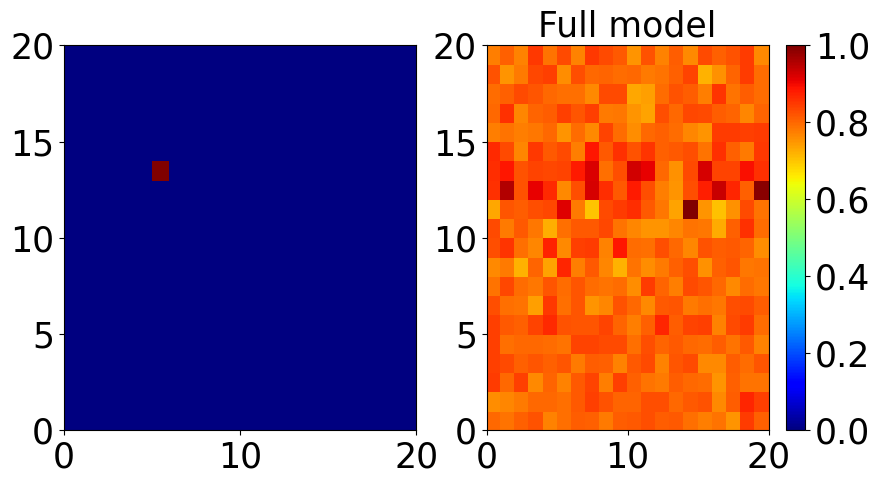

In [6]:
H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, xpix=20, ypix=20, font_size=25)
